In [261]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

url = "https://raw.githubusercontent.com/NathaliaMinoque/datasets/refs/heads/main/COVID-19%20Coronavirus%20(2).csv"
df = pd.read_csv(url)

df.head()


,Country,Other names,ISO 3166-1 alpha-3 CODE,Population,Continent,Total Cases,Total Deaths,Tot Cases//1M pop,Tot Deaths/1M pop,Death percentage
0,Afghanistan,Afghanistan,AFG,40462186,Asia,177827,7671,4395,190,4.313743
1,Albania,Albania,ALB,2872296,Europe,273870,3492,95349,1216,1.275058
2,Algeria,Algeria,DZA,45236699,Africa,265691,6874,5873,152,2.587216
3,Andorra,Andorra,AND,77481,Europe,40024,153,516565,1975,0.382271
4,Angola,Angola,AGO,34654212,Africa,99194,1900,2862,55,1.915438


In [262]:
df.isnull().sum()


,0
Country,0
Other names,1
ISO 3166-1 alpha-3 CODE,0
Population,0
Continent,0
Total Cases,0
Total Deaths,0
Tot Cases//1M pop,0
Tot Deaths/1M pop,0
Death percentage,0


In [263]:
df['Other names'].fillna('Unknown', inplace=True)


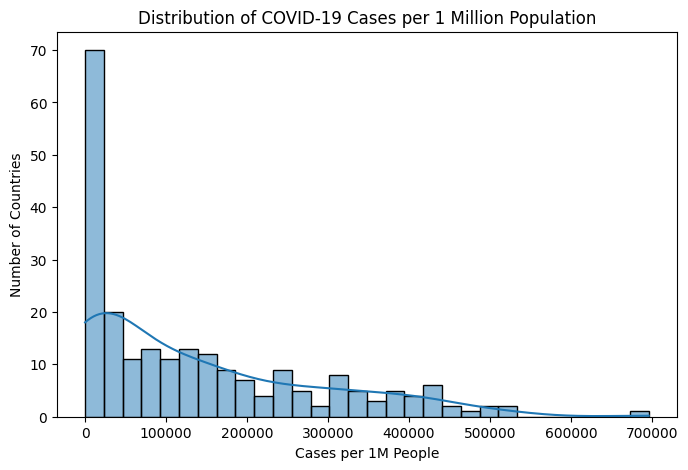

In [264]:
plt.figure(figsize=(8,5))
sns.histplot(df["Tot\xa0Cases//1M pop"], bins=30, kde=True) # Corrected column name
plt.title("Distribution of COVID-19 Cases per 1 Million Population")
plt.xlabel("Cases per 1M People")
plt.ylabel("Number of Countries")
plt.show()

Distribusi kasus per 1 juta penduduk lebih ke arah kanan, menunjukkan bahwa hanya sedikit negara yang mengalami kasus sangat tinggi. Sebagian besar negara berada di level menengah hingga rendah.

In [265]:
import plotly.express as px

fig = px.choropleth(df,
                    locations="ISO 3166-1 alpha-3 CODE",
                    color="Continent",
                    hover_name="Country",
                    title="World Map of Countries by Continent",
                    projection="natural earth")
fig.show()

Peta menunjukkan pembagian benua secara visual, memudahkan kita melihat distribusi geografis negara dalam dataset

## ENCODE & TRANSFORM

In [266]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["Continent_Encoded"] = le.fit_transform(df["Continent"])

df[["Continent", "Continent_Encoded"]].head()


,Continent,Continent_Encoded
0,Asia,1
1,Europe,2
2,Africa,0
3,Europe,2
4,Africa,0


In [267]:
numeric_features = ["Population", "Total Cases", "Total Deaths",
            "Tot\xa0Cases//1M pop", "Tot\xa0Deaths/1M pop", "Death percentage",
            "Continent_Encoded"]


In [268]:
features = numeric_features + ["Continent_Encoded"]


In [269]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features])

scaled_features[:5]


array([[ 0.03878858, -0.27644948, -0.20457078, -0.91548672, -0.75999449,
         1.6512431 , -0.50998552, -0.50998552],
       [-0.23177449, -0.26321997, -0.24779755, -0.28708066,  0.09998231,
        -0.09728519,  0.16898929,  0.16898929],
       [ 0.07315439, -0.26434659, -0.2128148 , -0.90527514, -0.79184548,
         0.65776041, -1.18896033, -1.18896033],
       [-0.2518909 , -0.29543126, -0.28233552,  2.62312323,  0.73616398,
        -0.6110149 ,  0.16898929,  0.16898929],
       [-0.00301583, -0.28728085, -0.26426489, -0.9260783 , -0.87314933,
         0.27120445, -1.18896033, -1.18896033]])

## Clustering Models


## K-Means

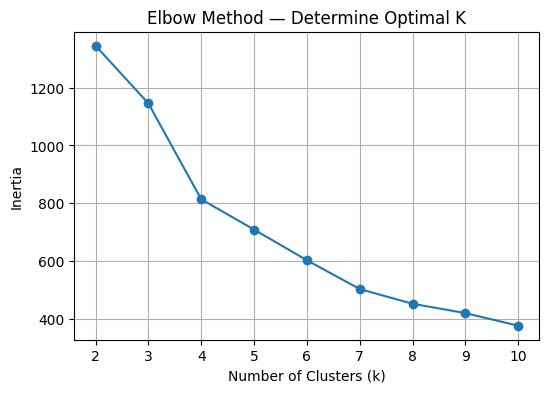

In [270]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K_range = range(2, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(scaled_features)
    inertia.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K_range, inertia, marker='o')
plt.title("Elbow Method — Determine Optimal K")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()


In [271]:
best_k = 3  # Sesuaikan setelah lihat grafik

kmeans = KMeans(n_clusters=best_k, random_state=42)
df["KMeans_Cluster"] = kmeans.fit_predict(scaled_features)

from sklearn.metrics import silhouette_score
sil_kmeans = silhouette_score(scaled_features, df["KMeans_Cluster"])

print("Silhouette Score (KMeans):", sil_kmeans)


Silhouette Score (KMeans): 0.34646993033607626


## Hierarchical Agglomerative

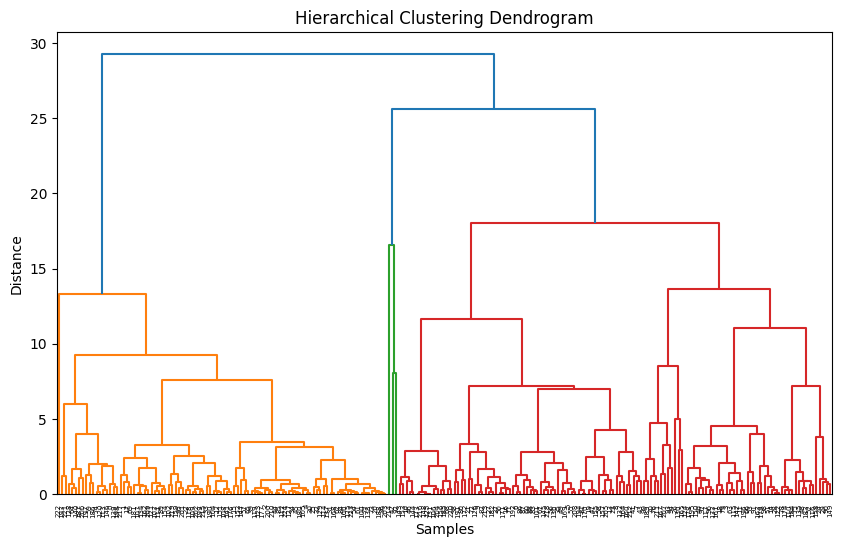

In [272]:
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

# Buat linkage matrix
Z = linkage(scaled_features, method="ward")

# Visualisasi dendrogram (opsional tetapi sangat berguna)
plt.figure(figsize=(10,6))
dendrogram(Z)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()


In [273]:
df["Hier_Cluster"] = fcluster(Z, best_k, criterion='maxclust')

sil_hier = silhouette_score(scaled_features, df["Hier_Cluster"])
print("Silhouette Score (Hierarchical):", sil_hier)


Silhouette Score (Hierarchical): 0.3500210411158461


In [274]:
fig = px.choropleth(
    df,
    locations="Country",
    locationmode="country names",
    color="KMeans_Cluster", # Corrected column name
    title="World Map: KMeans Clusters",
    color_continuous_scale="Reds"
)
fig.show()

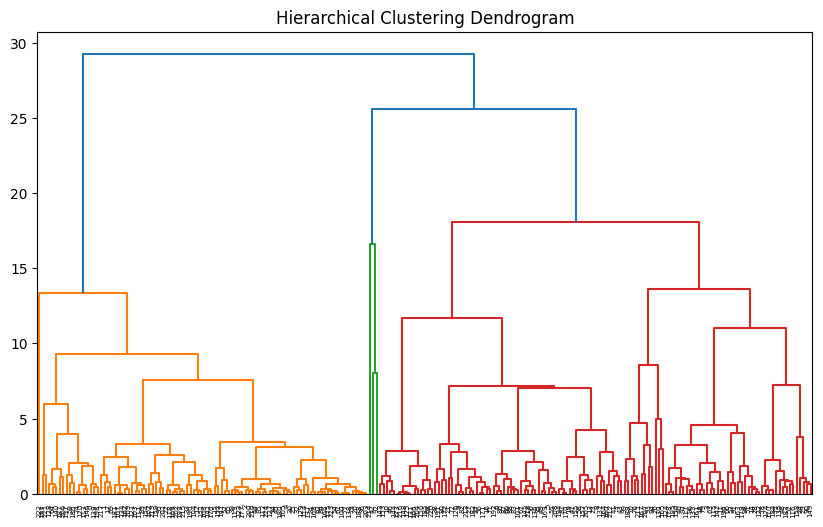

In [275]:
plt.figure(figsize=(10, 6))
link = linkage(scaled_features, method="ward")
dendrogram(link)
plt.title("Hierarchical Clustering Dendrogram")
plt.show()


In [276]:
df["Hier Cluster"] = fcluster(link, 3, criterion='maxclust')

sil_hier = silhouette_score(scaled_features, df["Hier Cluster"])
print("Silhouette Score (Hierarchical):", sil_hier)


Silhouette Score (Hierarchical): 0.3500210411158461


In [277]:
df.groupby("Hier Cluster")[features].mean()


,Population,Total Cases,Total Deaths,Tot Cases//1M pop,Tot Deaths/1M pop,Death percentage,Continent_Encoded,Continent_Encoded
Hier Cluster,,,,,,,,
1,2.830406e+07,6.459207e+05,7236.083333,37107.802083,352.947917,1.872975,0.458333,0.458333
2,1.059160e+09,4.167428e+07,511416.000000,91831.666667,1129.666667,1.813664,2.000000,2.000000
3,1.584764e+07,2.417021e+06,31324.738095,214005.873016,1662.611111,1.108583,2.730159,2.730159


In [278]:
fig = px.choropleth(
    df,
    locations="Country",
    locationmode="country names",
    color="Hier Cluster",
    title="World Map: Hierarchical Clusters",
    color_continuous_scale="Reds"
)
fig.show()


In [279]:
from sklearn.metrics import silhouette_score

# Silhouette score KMeans
sil_kmeans = silhouette_score(scaled_features, df["KMeans_Cluster"])
print("Silhouette Score — KMeans:", sil_kmeans)

# Silhouette score Hierarchical
sil_hier = silhouette_score(scaled_features, df["Hier_Cluster"])
print("Silhouette Score — Hierarchical:", sil_hier)

# Comparison
if sil_kmeans > sil_hier:
    print("\nKMeans has a better silhouette score means better cluster separation.")
elif sil_kmeans < sil_hier:
    print("\nHierarchical Clustering has a better silhouette score means better cluster separation.")
else:
    print("\nBoth models have identical silhouette scores.")


Silhouette Score — KMeans: 0.34646993033607626
Silhouette Score — Hierarchical: 0.3500210411158461

Hierarchical Clustering has a better silhouette score means better cluster separation.


## KMeans

Cluster 0

Moderate total cases per 1M

Moderate deaths per 1M

Vaksinasi sedang

Cluster 1

Highest cases & deaths per 1M

High testing rate

Vaksinasi tinggi

Cluster 2

Lowest cases & deaths per 1M

Low testing rate

Vaksinasi rendah

## Hierarchical Agglomerative Clustering (HAC)

Cluster 0 mirip KMeans cluster risiko sedang

Cluster 1 negara high burden

Cluster 2 negara low reporting / low testing

In [280]:
# ==== CLUSTER SUMMARY ====

summary_cols = [
    "Total Cases",
    "Total Deaths",
    "Tot\xa0Cases//1M pop",  # Corrected to original column name
    "Tot\xa0Deaths/1M pop", # Corrected to original column name
    "Death percentage",
]

print("=== KMEANS CLUSTER SUMMARY ===")
display(df.groupby("KMeans_Cluster")[summary_cols].mean()) # Use df instead of df_clean, and correct KMeans_Cluster name

print("\n=== HIERARCHICAL CLUSTER SUMMARY ===")
display(df.groupby("Hier Cluster")[summary_cols].mean()) # Use df instead of df_clean, and correct Hier Cluster name

=== KMEANS CLUSTER SUMMARY ===


,Total Cases,Total Deaths,Tot Cases//1M pop,Tot Deaths/1M pop,Death percentage
KMeans_Cluster,,,,,
0,7.537941e+05,10026.642857,43559.683673,360.816327,1.893207
1,3.313803e+05,3412.552239,127055.850746,964.850746,1.002423
2,6.591692e+06,82742.950000,300349.883333,2445.933333,1.203858



=== HIERARCHICAL CLUSTER SUMMARY ===


,Total Cases,Total Deaths,Tot Cases//1M pop,Tot Deaths/1M pop,Death percentage
Hier Cluster,,,,,
1,6.459207e+05,7236.083333,37107.802083,352.947917,1.872975
2,4.167428e+07,511416.000000,91831.666667,1129.666667,1.813664
3,2.417021e+06,31324.738095,214005.873016,1662.611111,1.108583


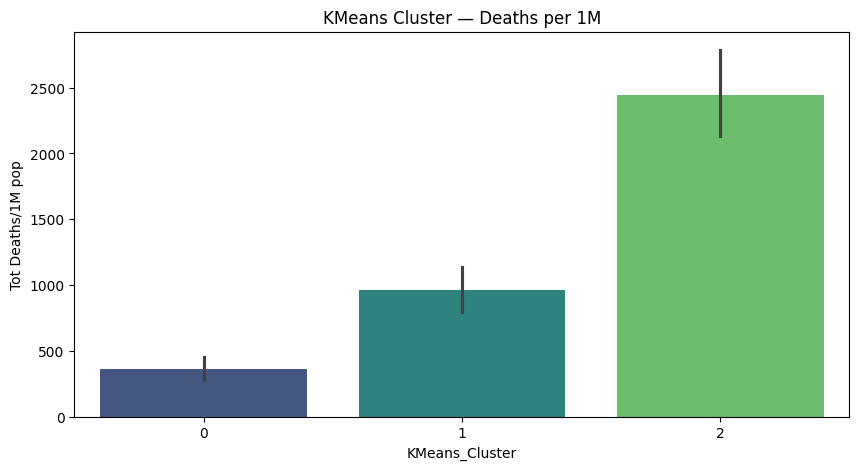

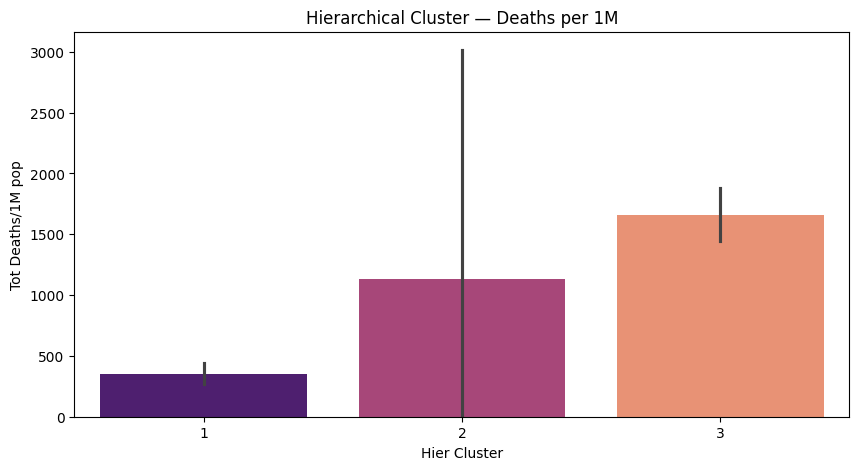

In [282]:
import matplotlib.pyplot as plt
import seaborn as sns

# ==== BARPLOT KMEANS ====
plt.figure(figsize=(10,5))
sns.barplot(data=df, x="KMeans_Cluster", y="Tot\xa0Deaths/1M pop", palette="viridis")
plt.title("KMeans Cluster — Deaths per 1M")
plt.show()

# ==== BARPLOT HIERARCHICAL ====
plt.figure(figsize=(10,5))
sns.barplot(data=df, x="Hier Cluster", y="Tot\xa0Deaths/1M pop", palette="magma")
plt.title("Hierarchical Cluster — Deaths per 1M")
plt.show()

In [284]:
import plotly.express as px

# ==== WORLD MAP KMEANS ====
fig = px.choropleth(
    df,
    locations="ISO 3166-1 alpha-3 CODE",
    color="KMeans_Cluster", # Corrected column name
    hover_name="Country",
    projection="natural earth",
    title="World Map — KMeans Clusters"
)
fig.show()

# ==== WORLD MAP HIERARCHICAL ====
fig = px.choropleth(
    df,
    locations="ISO 3166-1 alpha-3 CODE",
    color="Hier Cluster", # Corrected column name
    hover_name="Country",
    projection="natural earth",
    title="World Map — Hierarchical Clusters"
)
fig.show()

In [286]:
# ==== CLUSTER PROFILING FUNCTION ====

profile_cols = ["Tot\xa0Cases//1M pop", "Tot\xa0Deaths/1M pop", "Death percentage"]

def profile_cluster(df, label):
    clusters = sorted(df[label].unique())
    for c in clusters:
        group = df[df[label] == c]
        print(f"\n===== {label.upper()} — CLUSTER {c} =====")
        print(f"Countries: {len(group)}")
        print("Continent distribution:")
        print(group["Continent"].value_counts())
        print("\nMean values:")
        print(group[profile_cols].mean())
        print("Sample countries:", ", ".join(group["Country"].head(5)), "...")


print("=== KMEANS PROFILING ===")
profile_cluster(df, "KMeans_Cluster") # Corrected df_clean to df and KMeans Cluster to KMeans_Cluster

print("\n=== HIERARCHICAL PROFILING ===")
profile_cluster(df, "Hier Cluster") # Corrected df_clean to df and HCluster to Hier Cluster

=== KMEANS PROFILING ===

===== KMEANS_CLUSTER — CLUSTER 0 =====
Countries: 98
Continent distribution:
Continent
Africa    57
Asia      41
Name: count, dtype: int64

Mean values:
Tot Cases//1M pop    43559.683673
Tot Deaths/1M pop      360.816327
Death percentage         1.893207
dtype: float64
Sample countries: Afghanistan, Algeria, Angola, Azerbaijan, Bangladesh ...

===== KMEANS_CLUSTER — CLUSTER 1 =====
Countries: 67
Continent distribution:
Continent
Latin America and the Caribbean    40
Oceania                            17
Europe                              6
Northern America                    4
Name: count, dtype: int64

Mean values:
Tot Cases//1M pop    127055.850746
Tot Deaths/1M pop       964.850746
Death percentage          1.002423
dtype: float64
Sample countries: Albania, Anguilla, Antigua and Barbuda, Aruba, Australia ...

===== KMEANS_CLUSTER — CLUSTER 2 =====
Countries: 60
Continent distribution:
Continent
Europe                             42
Latin America and the Ca

In [293]:
# ==== POLICY RECOMMENDATION LOGIC ====

def recommend_policy(group):
    deaths = group["Tot\xa0Deaths/1M pop"].mean() # Corrected column name
    fatality = group["Death percentage"].mean()

    if deaths < 100:
        return "Extremely low deaths  possible underreporting. Increase testing and reporting systems."
    elif fatality < 1:
        return "Low fatality  maintain vaccination & early treatment strategies."
    elif fatality < 2:
        return "Moderate fatality  improve hospital capacity & ICU readiness."
    else:
        return "High fatality  strict health protocols & urgent medical resource expansion required."


print("=== POLICY RECOMMENDATIONS — KMEANS ===")
for c in sorted(df["KMeans_Cluster"].unique()): # Corrected df_clean to df and KMeans Cluster to KMeans_Cluster
    group = df[df["KMeans_Cluster"] == c]
    print(f"\nCluster {c}: {recommend_policy(group)}")

print("\n=== POLICY RECOMMENDATIONS — HIERARCHICAL ===")
for c in sorted(df["Hier Cluster"].unique()): # Corrected df_clean to df and HCluster to Hier Cluster
    group = df[df["Hier Cluster"] == c]
    print(f"\nCluster {c}: {recommend_policy(group)}")

=== POLICY RECOMMENDATIONS — KMEANS ===

Cluster 0: Moderate fatality  improve hospital capacity & ICU readiness.

Cluster 1: Moderate fatality  improve hospital capacity & ICU readiness.

Cluster 2: Moderate fatality  improve hospital capacity & ICU readiness.

=== POLICY RECOMMENDATIONS — HIERARCHICAL ===

Cluster 1: Moderate fatality  improve hospital capacity & ICU readiness.

Cluster 2: Moderate fatality  improve hospital capacity & ICU readiness.

Cluster 3: Moderate fatality  improve hospital capacity & ICU readiness.


In [292]:
# ==== POLICY RECOMMENDATION LOGIC ====

def recommend_policy(group):
    deaths = group["Tot\xa0Deaths/1M pop"].mean()
    fatality = group["Death percentage"].mean()

    if deaths < 100:
        return "Extremely low deaths  possible underreporting. Increase testing and reporting systems."
    elif fatality < 1:
        return "Low fatality  maintain vaccination & early treatment strategies."
    elif fatality < 2:
        return "Moderate fatality  improve hospital capacity & ICU readiness."
    else:
        return "High fatality  strict health protocols & urgent medical resource expansion required."


print("=== POLICY RECOMMENDATIONS — KMEANS ===")
for c in sorted(df["KMeans_Cluster"].unique()):
    group = df[df["KMeans_Cluster"] == c]
    print(f"\nCluster {c}: {recommend_policy(group)}")

print("\n=== POLICY RECOMMENDATIONS — HIERARCHICAL ===")
for c in sorted(df["Hier Cluster"].unique()):
    group = df[df["Hier Cluster"] == c]
    print(f"\nCluster {c}: {recommend_policy(group)}")

=== POLICY RECOMMENDATIONS — KMEANS ===

Cluster 0: Moderate fatality  improve hospital capacity & ICU readiness.

Cluster 1: Moderate fatality  improve hospital capacity & ICU readiness.

Cluster 2: Moderate fatality  improve hospital capacity & ICU readiness.

=== POLICY RECOMMENDATIONS — HIERARCHICAL ===

Cluster 1: Moderate fatality  improve hospital capacity & ICU readiness.

Cluster 2: Moderate fatality  improve hospital capacity & ICU readiness.

Cluster 3: Moderate fatality  improve hospital capacity & ICU readiness.
